In [3]:
%matplotlib notebook
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pygalmesh
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import sys
sys.path.append('..')
import project

In [5]:
case_name = 'Case1Pack'
ee_phase = 50
ei_phase =  0

In [6]:
ds = project.imaging.Emory4DCTDataset('../data/Emory-4DCT', case_names=[case_name], phases=[ei_phase, ee_phase])
ds.load_niftis()
ds.load_masks(roi=['lung_combined_mask', 'body'])
ds.load_displacements(fixed_phase=ee_phase)

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/body.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/body.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T00_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T50_T50.nii.gz


In [26]:
case = ds[0]

ee_anat_image = case.array.sel(phase=50)
ei_anat_image = case.array.sel(phase=0)

ee_lung_mask = case.mask.sel(phase=50, roi='lung_combined_mask')
ei_lung_mask = case.mask.sel(phase=0, roi='lung_combined_mask')

ee_overlay = (ee_lung_mask + 1) / 2
ei_overlay = (ei_lung_mask + 1) / 2

reg_disp_image = case.disp.sel(phase=0)

In [31]:
def get_grid_points(shape, resolution, flatten=False):
    assert len(shape) == len(resolution)
    coords = [np.arange(s) * r for s,r in zip(shape, resolution)]
    points = np.stack(np.meshgrid(*coords, indexing='ij'), axis=-1)
    if flatten:
        points = points.reshape(-1, len(shape))
    return points

points = get_grid_points(case.shape, case.resolution, flatten=False)
points.shape

(256, 256, 94, 3)

<IPython.core.display.Javascript object>


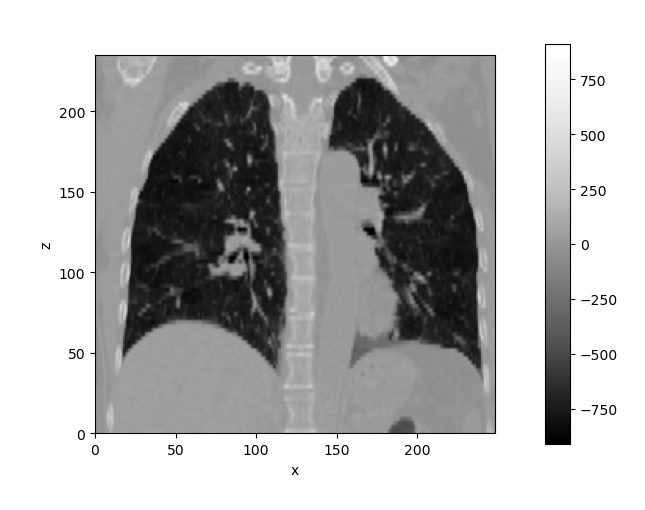

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [28]:
project.visual.view(ee_anat_image * (ee_lung_mask + 1)/2, x='x', y='z', cmap='Greys_r')

<IPython.core.display.Javascript object>


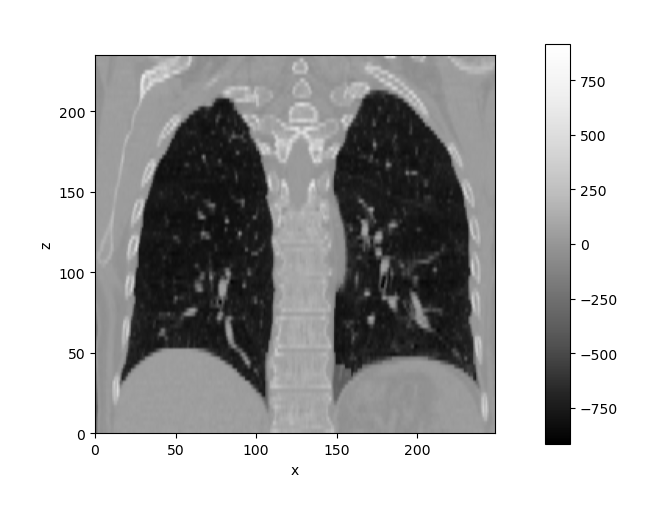

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [32]:
project.visual.view(ei_anat_image * (ei_lung_mask + 1)/2, x='x', y='z', cmap='Greys_r')

<IPython.core.display.Javascript object>


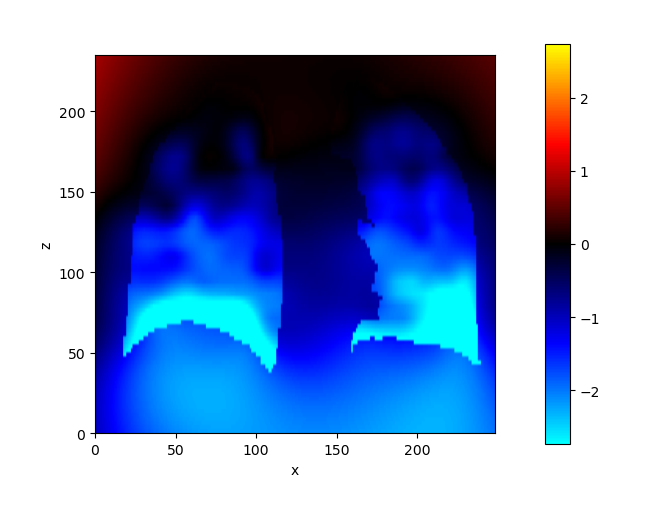

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [33]:
project.visual.view(reg_disp_image * (ee_lung_mask + 1)/2, x='x', y='z')

In [35]:
%%time
ee_lung_mesh = pygalmesh.generate_from_array(
    ee_lung_mask.values.astype(np.uint16),
    voxel_size=case.resolution,
    max_cell_circumradius=5.0
)

vertices = ee_lung_mesh.points
facets = ee_lung_mesh.cells[0].data
tetras = ee_lung_mesh.cells[1].data

angles = project.meshing.compute_angles_to_interior(vertices, facets, tetras)

CPU times: user 34.1 s, sys: 1.71 s, total: 35.8 s
Wall time: 36.2 s


<IPython.core.display.Javascript object>


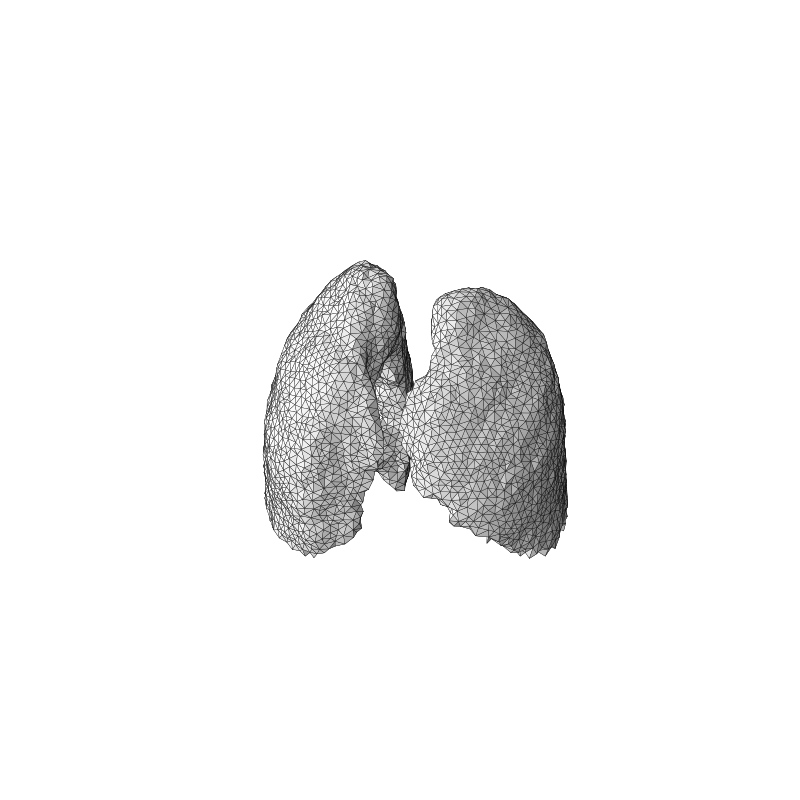

In [36]:
fig, ax = project.meshing.plot_mesh(
    vertices,
    facets[angles > 0],
    facecolors='white',
    edgecolors='black',
    shade=True,
    linewidth=0.2,
    figsize=(8,8)
)
ax.grid(False)
ax.xaxis.set_pane_color((1,1,1,0))
ax.yaxis.set_pane_color((1,1,1,0))
ax.zaxis.set_pane_color((1,1,1,0))
ax.set_axis_off()

In [38]:
vertices.mean(axis=0)

array([123.42768, 122.15623, 117.20397], dtype=float32)

In [40]:
points.mean(axis=(0,1,2))

array([123.67500365, 123.67500365, 116.25      ])

In [41]:
import meshio
import fenics as fe
from mpi4py import MPI

In [45]:
def convert_to_fe_mesh(points, cells):
    mesh_file = 'temp.xdmf'
    meshio.write_points_cells(mesh_file, points, [(cells.type, cells.data)])
    fe_mesh = fe.Mesh()
    with fe.XDMFFile(MPI.COMM_WORLD, mesh_file) as f:
        f.read(fe_mesh)
    return fe_mesh

ee_lung_fe_mesh = convert_to_fe_mesh(ee_lung_mesh.points, ee_lung_mesh.cells[1])
ee_lung_fe_mesh

In [42]:
reg_disp_image

<xarray.DataArray 'displacement' (x: 256, y: 256, z: 94, component: 3)> Size: 148MB
array([[[[-0.19725657,  0.18855788,  3.72065806],
         [-0.19202898,  0.22886273,  3.72118616],
         [-0.18680154,  0.2691676 ,  3.72171426],
         ...,
         [-0.99159646,  1.33488357,  2.63766527],
         [-0.97847289,  1.33290517,  2.64906716],
         [-0.96534938,  1.33092666,  2.66046929]],

        [[-0.19068624,  0.17473309,  3.68711996],
         [-0.18529861,  0.21557614,  3.6876483 ],
         [-0.17991096,  0.25641915,  3.68817663],
         ...,
         [-0.98869127,  1.32499492,  2.62248778],
         [-0.97549385,  1.32283068,  2.63378382],
         [-0.96229696,  1.32066631,  2.64507985]],

        [[-0.18411592,  0.16090827,  3.65358114],
         [-0.17856809,  0.20228951,  3.65410995],
         [-0.17302063,  0.24367069,  3.65463829],
         ...,
...
         ...,
         [ 1.85563898, -2.40501404,  1.17633808],
         [ 1.88574946, -2.40881371,  1.20866549],
         [ 1.91586041, -2.41261339,  1.24099326]],

        [[ 3.06607032, -5.70032978, -2.49166203],
         [ 3.04808044, -5.6315341 , -2.43805313],
         [ 3.03009081, -5.56273794, -2.384444  ],
         ...,
         [ 1.85949504, -2.43069506,  1.18595457],
         [ 1.88910162, -2.43423462,  1.21795213],
         [ 1.91870844, -2.43777442,  1.24994993]],

        [[ 3.06481266, -5.72020769, -2.47239232],
         [ 3.04646468, -5.65178394, -2.41900229],
         [ 3.02811646, -5.5833602 , -2.36561227],
         ...,
         [ 1.86335087, -2.45637584,  1.19557106],
         [ 1.89245379, -2.45965552,  1.22723877],
         [ 1.92155671, -2.46293497,  1.25890672]]]])
Coordinates:
    phase      int64 8B 0
  * x          (x) float64 2kB 0.0 0.97 1.94 2.91 ... 244.4 245.4 246.4 247.4
  * y          (y) float64 2kB 0.0 0.97 1.94 2.91 ... 244.4 245.4 246.4 247.4
  * z          (z) float64 752B 0.0 2.5 5.0 7.5 10.0 ... 225.0 227.5 230.0 232.5
  * component  (component) <U1 12B 'x' 'y' 'z'

<IPython.core.display.Javascript object>


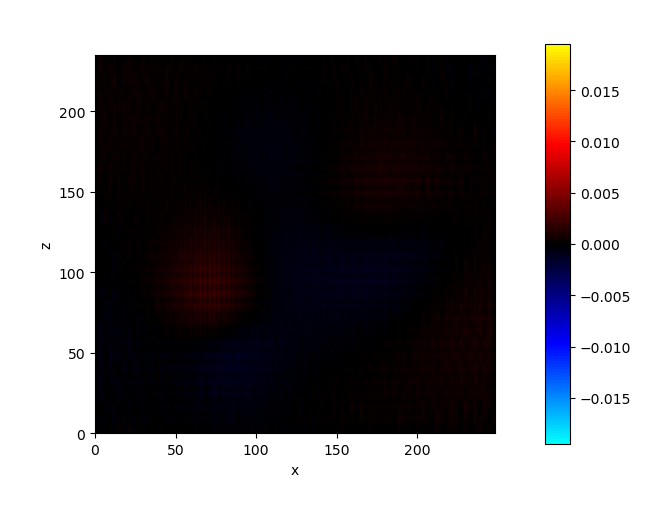

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


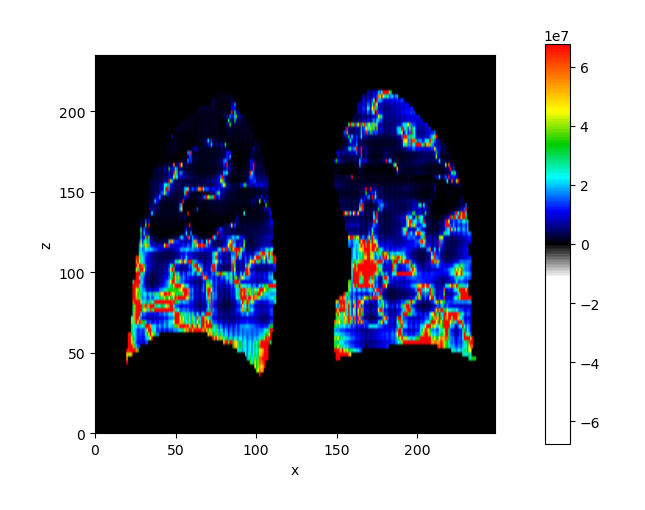

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [43]:
# direct inversion

dx_image = reg_disp_image.differentiate('x')
dy_image = reg_disp_image.differentiate('y')
dz_image = reg_disp_image.differentiate('z')

dxx_image = dx_image.differentiate('x')
dyy_image = dy_image.differentiate('y')
dzz_image = dz_image.differentiate('z')

laplacian_image = dxx_image + dyy_image + dzz_image

rho = 1000
omega = 2 * np.pi * 1
elast_image = -rho * omega**2 * (reg_disp_image.sum('component') / laplacian_image.sum('component'))
elast_image.name = 'elasticity'

project.visual.view(laplacian_image, x='x', y='z')
project.visual.view(np.abs(elast_image) * ee_lung_mask, x='x', y='z', cmap=project.visual.mre_color_map())

$$
\begin{align*}
    -\nabla\cdot\sigma &= \mathbf{b} \\
    -\int_\Omega (\nabla\cdot\sigma)\cdot\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} \\
    \int_\Omega \sigma\cdot\nabla\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} (\sigma\cdot\mathbf{n})\cdot\mathbf{v} \,d\mathbf{s} \\
    \int_\Omega \sigma(\mathbf{u})\cdot\epsilon(\mathbf{v}) \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} \mathbf{T}\cdot\mathbf{v} \,d\mathbf{s}
\end{align*}
$$

In [77]:
def solve_fem(mesh):
    
    # define physical parameters
    g = 9.81e-3  # gravitational acceleration
    rho = 1e3 # mass density
    
    E = 3e3  # Young's modulus
    nu = 0.4 # Poisson's ratio

    lam = E*nu/((1+nu)*(1-2*nu))
    mu = E/(2*(1+nu))
    
    print(lam, mu)
    
    # create mesh and function space
    mesh = convert_to_fe_mesh(mesh.points, mesh.cells[1])
    V = fe.VectorFunctionSpace(mesh, 'P', 1)
    
    # set displacement boundary condition
    def clamped_boundary(x, on_boundary):
        return on_boundary
    
    bc = fe.DirichletBC(V, fe.Constant((0,0,0)), clamped_boundary)
    
    # body force and traction
    b = fe.Constant((0, 0, -g*rho))
    T = fe.Constant((0, 0, 0))
    
    # define stress and strain
    def epsilon(u):
        return (fe.grad(u) + fe.grad(u).T) / 2

    def sigma(u):
        I = fe.Identity(u.geometric_dimension())
        return lam * fe.div(u) * I + 2 * mu * epsilon(u)

    # setup variational problem
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)

    a = fe.inner(sigma(u), epsilon(v)) * fe.dx
    L = fe.dot(b, v) * fe.dx + fe.dot(T, v) * fe.ds
    
    # solve for displacement
    u = fe.Function(V)
    fe.solve(a == L, u, bc)
    
    return u

disp_fe_func = solve_fem(ee_lung_mesh)

4285.714285714287 1071.4285714285716


<IPython.core.display.Javascript object>


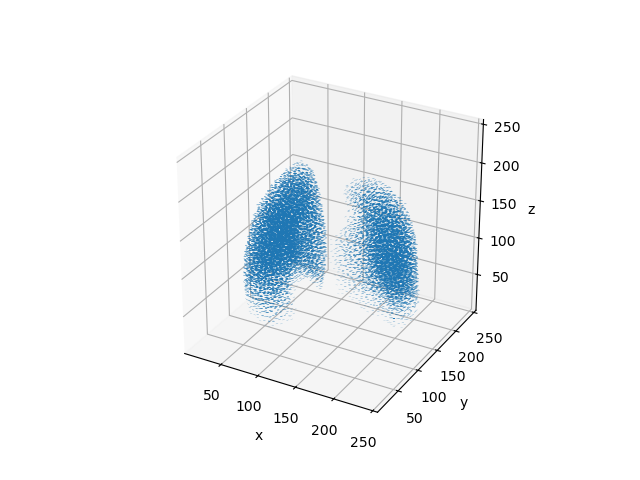

44.90883953489049


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>)

In [78]:
def estimate_limit(x, expand=0.1):
    x_min, x_max = np.min(x), np.max(x)
    x_range = (x_max - x_min)
    x_min -= expand * x_range / 2
    x_max += expand * x_range / 2
    return x_min, x_max

def plot_func(f):

    mesh = f.function_space().mesh()

    vertices = mesh.coordinates()
    n_vertices = mesh.num_vertices()
    values = f.compute_vertex_values(mesh)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d', aspect='equal')

    X = [vertices[:,i] for i in range(3)]
    U = [values[i * n_vertices:(i + 1) * n_vertices] for i in range(3)]
    
    print(np.mean(np.linalg.norm(U, axis=1), axis=0))
       
    args = X + U
    ax.quiver(*args)
    
    ax.set_xlim(estimate_limit(vertices.flatten()))
    ax.set_ylim(estimate_limit(vertices.flatten()))
    ax.set_zlim(estimate_limit(vertices.flatten()))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    return fig, ax

plot_func(disp_fe_func)

In [86]:
points = get_grid_points(case.shape, case.resolution, flatten=True)

disp_fe_func.set_allow_extrapolation(True)
sim_disp_values = []
for point in points:
    sim_disp_values.append(disp_fe_func(*point))

sim_disp_image = np.array(sim_disp_values).reshape(case.shape + (3,))

<IPython.core.display.Javascript object>


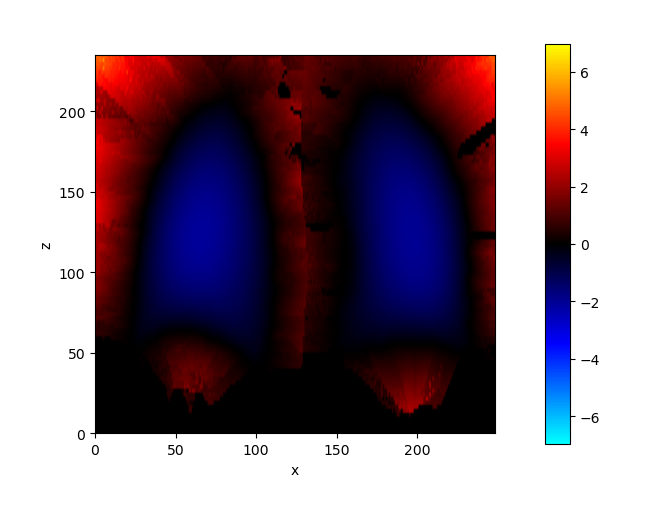

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [87]:
project.visual.view(reg_disp_image * 0 + sim_disp_image, x='x', y='z')